# TAOS drifter deployments: tool development


- [ ] approximate time for deployment?
- [ ] GPS position onboard delphy: degrés décimaux, deg/min decimaux, deg/min/sec ?
- [ ] Outil de cartographie ? (rentrée positions)
- [ ] prise électrique à bord du Delphy

Land tool:

- [ ] automatic refresh: download and print in table
- [ ] high res bathymetry


Ship tool:

- [ ] manual input of coordinates
- [ ] update route with click


[Marc](https://marc.ifremer.fr/resultats/courants/modeles_mars2d_atlantique_nord_est/(variable)/courant/(typevisu)/map/(zoneid)/7418/(type)/canvas#appTop)


In [1]:
import os
from glob import glob

from datetime import datetime
from time import sleep

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import pyproj

import taos.utils as ut
import taos.insitu as ins
from taos.insitu import rad2deg, knot, lonc, latc

---

## useful metrics

In [2]:
ins.metrics_cheatsheet(lonc, latc)

 lon: 1 deg = 72.44km,  0.1 deg = 7.2km,  0.01 deg = 724.4m,  0.001 deg = 72.4m
 lon: 1 deg = 72.44km,  1 min = 1207.3m,  .1 min = 120.7m,  0.01 min = 12.1m
 lon: 1 deg = 72.44km,  1 sec = 20.1m,  .1 sec = 2.0m
-----------------------------------------------------------------
 lat: 1 deg = 111.23km,  0.1 deg = 11.1km,  0.01 deg = 1112.2m,  0.001 deg = 111.2m
 lat: 1 deg = 111.23km,  1 min = 1853.7m,  .1 min = 185.4m,  0.01 min = 18.5m
 lat: 1 deg = 111.23km,  1 sec = 30.9m,  .1 sec = 3.1m


🐷🐷🐷🐷🐨🌼🌼🌼💐💐🌾🌖🌾😋😋👩‍🦳👩‍🦳§😄😁😁😁😀😄😄(😃😄(😚😚😗)🙃😇😇😇😇🥳🥳😏🥳🥳😏🥳😏🥳)😡😡😡😡😡😡👹👹👹👺👺👺👾👽👾😿😿😿😸😹👍🖐🏻👉🏽👀👥👥👥👥👥👥👥🧑🏽‍🦰🧑🏽‍🦰👱‍♂️👱‍♂️👱‍♂️👱‍♂️😡🤕à🤕🤕🤒😷

---

## course resolution 

\begin{align}
\delta x + u_o (\delta t + t_w) = u_s \cos(\theta) \delta t, \\
\delta y + v_o (\delta t + t_w) = u_s \sin(\theta) \delta t,
\end{align}


In [3]:
Uo = .5 + 1j*0 # m/s
dX = 0 - 1j*1e3 # m
speed = 10*0.5 # m/s
time_waiting = 5*60 # seconds

theta, dt, _, X_launch, Us = ins.solve_route_heading(dX, speed, Uo, time_waiting)

print(f" New heading = {theta*rad2deg:.1f} at {speed/knot:.1f} knots ({speed:.1f}m/s), time to destination = {dt/60:.1f}min, waiting time: {time_waiting/60:.1f}min")

/Users/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 New heading = -75.8 at 9.7 knots (5.0m/s), time to destination = 3.4min, waiting time: 5.0min


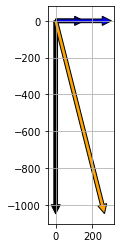

In [4]:
ins.plot_route_solution(dX, Us, Uo, dt, time_waiting)

---

## deployment geometry

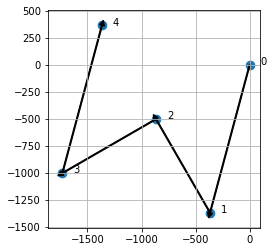

In [5]:
L, theta, N = 1e3, 30/rad2deg, 5
#X, dX = ins.build_polygon(L, theta, N, rotation=1)
X, dX = ins.build_square_with_center(L, theta, rotation=-1, center_loc=2)
ins.plot_polygon(X, dX)

In [6]:
lon_a, lat_a = -0.25, 49.33 # anchor point
lon, lat, X = ins.build_square_geo(lon_a, lat_a, L, theta, rotation=-1, center_loc=2)

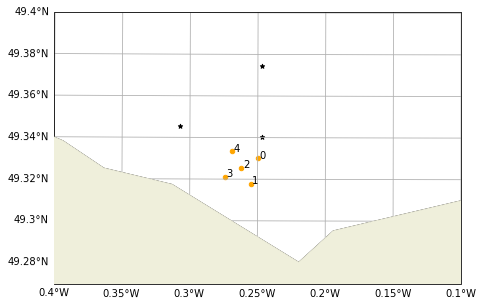

In [7]:
fac = ut.plot_bs(bathy=False, zoom=[-.4, -.1, 49.27, 49.4], vmax=30)
ax = fac["ax"]

ax.scatter(lon, lat, 20, color="orange", transform=ut.ccrs.PlateCarree())

for i in range(lon.size):
    ax.text(lon[i]+1e-3, lat[i], f"{i}", transform=ut.ccrs.PlateCarree())

_s = ins.stations
ax.scatter(_s.lon, _s.lat, 20, color="black", marker="*", transform=ut.ccrs.PlateCarree())

ax.set_aspect("equal")
ax.grid()

In [8]:
### solve route

solve_route_heading = ins.solve_route_heading
ll2xy = ins.ll2xy
xy2ll = ins.xy2ll
now = ins.now
one_second = ins.one_second


In [9]:
# anchor point
L, theta = 2e3, 0/rad2deg
lon_a, lat_a = -0.25, 49.33

Uo = .5 + 1j*0 # m/s
speed = 5*0.5 # m/s
time_waiting = 5*60 # seconds

lon, lat, X = ins.build_square_geo(lon_a, lat_a, L, theta, rotation=-1, center_loc=2)

# deployment at ship location
df = ins.deployments_route_schedule(lon_a, lat_a, speed, lon, lat, time_waiting, Uo)
# deployment at predetermined anchor location
#df = ins.deployments_route_schedule(lon_a-0.02, lat_a, speed, lon, lat, time_waiting, Uo
#                    lon_a=lon_a, lat_a=lat_a,
#                   )
# underway deployment at location 2 and beyond
#df = ins.deployments_route_schedule(lon_a-0.02, lat_a, speed, lon, lat, time_waiting, Uo
#                    lon_a=lon_a, lat_a=lat_a, time_a=now()-pd.Timedelta("1min"),
#                    skip=2,
#                   )

df

,time,lon,lat,heading,dt_route,dt_total,lon_deg,lon_min,lat_deg,lat_min
deployment,,,,,,,,,,
-1,2022-05-10 05:14:06.917783000,-0.250000,49.330000,NaN,NaN,NaN,-0.0,15.000000,49.0,19.800000
0,2022-05-10 05:19:07.917783000,-0.250033,49.330007,-3.455752,0.016667,5.016667,-0.0,15.001961,49.0,19.800419
1,2022-05-10 05:40:16.627198552,-0.268868,49.312047,-2.169901,16.145157,21.145157,-0.0,16.132105,49.0,18.722813
2,2022-05-10 05:59:08.012365303,-0.261038,49.330021,1.295150,13.856419,18.856419,-0.0,15.662285,49.0,19.801246
3,2022-05-10 06:14:24.679031969,-0.282248,49.330044,3.141593,10.277778,15.277778,-0.0,16.934858,49.0,19.802662
4,2022-05-10 06:42:35.944715072,-0.243041,49.347981,0.612624,23.187761,28.187761,-0.0,14.582489,49.0,20.878842


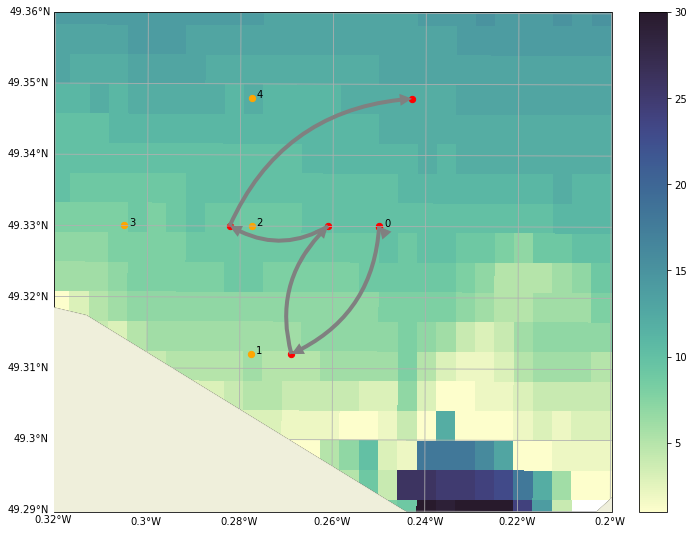

In [10]:
ins.plot_deployments_route(lon, lat, df, bathy=True)

In [11]:
# debug
if False:
    #opts = dict(n=256, options=dict(disp=True))
    #opts = dict(n=512)
    _dX = dX[0]
    theta, dt_route, dt_total, X_launch, Us = ins.solve_route_heading(_dX, speed, Uo, time_waiting)
    ins.plot_route_solution(_dX, Us, Uo, dt_route, time_waiting)
    theta*rad2deg, dt_route/60, dt_total/60, X_launch, Us

---
## load drifter data

😹🧑🏽‍🦰🧑🏽‍🦰😸👺👺😍😍😌😍🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰😒😒😒😫😫😫😫😫😫😩😩😩😩😩😩😩😫😫😫😫😫😫😫😫😫😫😫🥵😬😬😬🙄🙄🙄🙄🙄😬😑😐🥶🥶🥶🥶🥶🥶🥶🥶😱😱😱😱🥵🥵🥶🥵🥵🥵🥵🥵🥵🥵🤮🥴🥴🤧🤧👶👶👶👶👥👥

🥶🥶🥶😚c😚😚😋🥅🥅🥅🥅🥊🥊🥊🥊🥊🥊🥊🥊🛷🛷🛷🛷🛷🛷🪂🪂🪂🪂🪂🪂🪂🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🎽🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷m🎿🎿🎿🎿🎿🎿🎿🎿🎿🎿🎿🎿⛷⛷⛷⛷⛷⛷🛹🛹🛹🛹🛹🛹🤸🤸🤸🤸🤸🤸🤸🤸🤸🤸🤸🤸⛹️‍♂️⛹️‍♂️⛹🏻‍♀️⛹️‍♂️🤺🤺🤺


In [12]:
#ins.fetch_drifter_data()

In [13]:
dr = ins.load_drifter_data()
dr_now = ins.extrapolate(dr)

In [14]:
anchor = "0-4351896"
#...

---
### monitoring

In [15]:
%matplotlib inline

In [ ]:
ins.monitor_drifters(refresh_time=5/60)

---
## ship tools: manual logging

In [16]:
devices = list(dr)

In [17]:
#import ipywidgets as widgets
#import datetime

#from ipywidgets import GridspecLayout
#from ipywidgets import Button, Layout, jslink, IntText, IntSlider

#def create_expanded_button(description, button_style):
#    return Button(description=description, button_style=button_style, layout=Layout(height='auto', width='auto'))


In [18]:

d = ins.dashboard()
d.grid

#

GridspecLayout(children=(Dropdown(description='Device:', layout=Layout(grid_area='widget001'), options=(), val…

---

In [ ]:

class dashboard_speed(object):
    
    def __init__(self):
        #
        self.build_dashboard()
        self.update() # time

    def build_dashboard(self):
        
        w = dict()

        w["button"] = widgets.Button(
            description='Compute',
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Click me',
            icon='check' # (FontAwesome names without the `fa-` prefix)
        )
        w["button"].on_click(self.compute)

        w["end_hour"] = widgets.Dropdown(
            options=np.arange(24),
            description='End - hour:',
            disabled=False,
        )

        w["end_minute"] = widgets.Dropdown(
            options=np.arange(60),
            description='End - minute:',
            disabled=False,
        )

        w["end_second"] = widgets.Dropdown(
            options=np.arange(60),
            description='End - second:',
            disabled=False,
        )

        w["end_lon_deg"] = widgets.Dropdown(
            options=["0W"], # to be generalized
            value="0W",
            description='End - lon [deg]:',
            disabled=False,
        )

        w["end_lon_min"] = widgets.Dropdown(
            options=np.arange(60),
            value=15,
            description='End - lon - [min]:',
            disabled=False,
        )

        w["end_lon_sec"] = widgets.FloatSlider(
            value=0.,
            min=0,
            max=60.0,
            step=0.1, # 0.1 sec = 2m
            description='End - lon [sec]:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )

        #w["end_lat_deg"] = widgets.Dropdown(
        #    options=["49N"], # to be generalized
        #    value="49N",
        #    description='End - lat [deg]:',
        #    disabled=False,
        #)

        w["end_lat_min"] = widgets.Dropdown(
            options=np.arange(60),
            value=19,
            description='End - lat [min]:',
            disabled=False,
        )

        w["end_lat_sec"] = widgets.FloatSlider(
            value=0.,
            min=0,
            max=60.0,
            step=0.1, # 0.1 sec = 2m
            description='End - lat [sec]:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )

        #
        grid = widgets.GridspecLayout(4, 3, height='200px', align_items="center")

        #grid[0, 0] = w["device"]
        grid[0, 1] = w["button"]

        #
        #grid[0, 2] = w["date"]
        grid[1, 2] = w["hour"]
        grid[2, 2] = w["minute"]
        #grid[3, 2] = w["second"]

        #
        #grid[1, 0] = w["lon_deg"]
        grid[2, 0] = w["lon_min"]
        #grid[3, 0] = w["lon_sec"]

        #
        #grid[1, 1] = w["lat_deg"]
        grid[2, 1] = w["lat_min"]
        #grid[3, 1] = w["lat_sec"]

        # store
        self.grid = grid
        self.w = w
        
    def update(self):
        _now = datetime.utcnow()
        self.w["date"].value = _now
        self.w["hour"].value = _now.hour
        self.w["minute"].value = _now.minute
        self.w["second"].value = _now.second
                
    def register(self, button):
        w = self.w
        #
        date = w["date"].value
        time = pd.Timestamp(year=date.year, month=date.month, day=date.day,
                            hour=w["hour"].value, minute=w["minute"].value, second=w["second"].value,
                           )
        #
        lond = w["lon_deg"].value
        lon = float(lond[:-1])
        if lond[-1]=="W":
            sign = -1
        else:
            sign = 1
        lon = sign * (lon + w["lon_min"].value/60 + w["lon_sec"].value/3600)
        #
        latd = w["lat_deg"].value
        lat = float(latd[:-1])
        if latd[-1]=="N":
            sign = 1
        else:
            sign = -1
        lat = sign * (lat + w["lat_min"].value/60 + w["lat_sec"].value/3600)
        #
        s = pd.Series(dict(device=w["device"].value,
                           time=time,
                           lon=lon,
                           lat=lat,
                          )
                     )
        # store
        (s.to_frame().T
         .rename_axis('event')
         .to_csv(self.log, mode='a', header=not os.path.exists(self.log))
        )
        
    def load_log(self):
        """load log file"""
        df = pd.read_csv(d.log, parse_dates=["time"])
        return df